In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
titanic_data = pd.read_csv('train.csv')

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices,test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

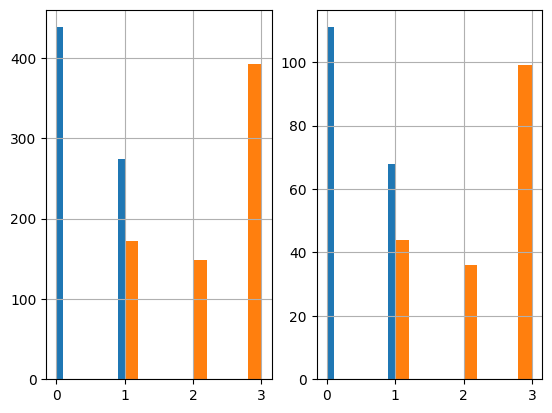

In [14]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()
plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
plt.show()

In [15]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
class AgeImputer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X


In [16]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 637 to 479
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          570 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [17]:
from sklearn.preprocessing import OneHotEncoder
class FeatureEncoder(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        encoder = OneHotEncoder()
        matrix=encoder.fit_transform(X[['Embarked']]).toarray()
        column_names=["C","S","Q","N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names=["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X

In [18]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [19]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer",AgeImputer()),
                    ("featureencoder",FeatureEncoder()),
                    ("featuredropper",FeatureDropper())])

In [20]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [21]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
637,638,0,2,31.000000,1,1,26.2500,0.0,0.0,1.0,0.0,1.0
781,782,1,1,17.000000,1,0,57.0000,0.0,0.0,1.0,1.0,0.0
667,668,0,3,29.653228,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
165,166,1,3,9.000000,0,2,20.5250,0.0,0.0,1.0,0.0,1.0
323,324,1,2,22.000000,1,1,29.0000,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
694,695,0,1,60.000000,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
249,250,0,2,54.000000,1,0,26.0000,0.0,0.0,1.0,0.0,1.0
145,146,0,2,19.000000,1,1,36.7500,0.0,0.0,1.0,0.0,1.0
580,581,1,2,25.000000,1,1,30.0000,0.0,0.0,1.0,1.0,0.0


In [22]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 637 to 479
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [23]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'],axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()
param_grid = [
    {"n_estimators": [10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
]
grid_search = GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [25]:
final_clf = grid_search.best_estimator_

In [26]:
final_clf

RandomForestClassifier(max_depth=10)

In [27]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [28]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
280,281,0,3,65.000000,0,0,7.750,0.0,1.0,0.0,0.0,1.0
377,378,0,1,27.000000,0,2,211.500,1.0,0.0,0.0,0.0,1.0
564,565,0,3,29.880764,0,0,8.050,0.0,0.0,1.0,1.0,0.0
510,511,1,3,29.000000,0,0,7.750,0.0,1.0,0.0,0.0,1.0
443,444,1,2,28.000000,0,0,13.000,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
188,189,0,3,40.000000,1,1,15.500,0.0,1.0,0.0,0.0,1.0
711,712,0,1,29.880764,0,0,26.550,0.0,0.0,1.0,0.0,1.0
422,423,0,3,29.000000,0,0,7.875,0.0,0.0,1.0,0.0,1.0
297,298,0,1,2.000000,1,2,151.550,0.0,0.0,1.0,1.0,0.0


In [29]:
X_test = strat_test_set.drop(['Survived'],axis=1)
y_test =  strat_test_set['Survived']
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [30]:
final_clf.score(X_data_test,y_data_test)

0.8100558659217877

In [31]:
final_data = pipeline.fit_transform(titanic_data)

In [32]:
final_data 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [33]:
X_final = final_data.drop(['Survived'],axis=1)
X_final.to_csv("DB.csv",index=False)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [34]:
prod_clf = RandomForestClassifier()
param_grid = [
    {"n_estimators": [10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
]
grid_search = GridSearchCV(prod_clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data_final,y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [35]:
prod_final_clf = grid_search.best_estimator_

In [36]:
prod_final_clf

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=200)

In [37]:
titanic_test_data = pd.read_csv("test.csv")

In [38]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [39]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\MSI\AppData\Local\Temp\ipykernel_10556\1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [40]:
X_final_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [41]:
X_data_final_test

array([[-1.72791209,  0.87348191,  0.3349926 , ..., -1.35067551,
        -0.75592895,  0.75592895],
       [-1.71962474,  0.87348191,  1.32553003, ...,  0.74037028,
         1.32287566, -1.32287566],
       [-1.71133739, -0.31581919,  2.51417495, ..., -1.35067551,
        -0.75592895,  0.75592895],
       ...,
       [ 1.71133739,  0.87348191,  0.65196458, ...,  0.74037028,
        -0.75592895,  0.75592895],
       [ 1.71962474,  0.87348191,  0.        , ...,  0.74037028,
        -0.75592895,  0.75592895],
       [ 1.72791209,  0.87348191,  0.        , ..., -1.35067551,
        -0.75592895,  0.75592895]])

In [42]:
predictions = prod_final_clf.predict(X_data_final_test)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [43]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("predictions.csv",index=False)

In [44]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [45]:
pd.to_pickle(prod_final_clf,r'C:\Users\MSI\Desktop\proj\proj20\ml\new_model.pickle')

In [46]:
model = pd.read_pickle(r"C:\Users\MSI\Desktop\proj\proj20\ml\new_model.pickle")

In [47]:


a = X_final_test.loc[1:300]
a

scalar = StandardScaler()
res = scalar.fit_transform(a)
ress = model.predict(res)
ress
    


array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], d